# Cohort 33 - Flower Image Classification Using ResNet50

In this project, utilized the ResNet50 model pre-trained on ImageNet and fine-tune it on the 102 Flower categories. The primary goal is to build a flower classifier capable of distinguishing between the diverse and closely related flower species in the dataset, by leveraging transfer learning to achieve high accuracy in a computationally efficient manner.

Dataset Details

- Number of Categories: 102
- Number of Images per Class: 40–258

Dataset Components

- Flower Images,
- Image Segmentations,
- Chi2 Distances,
- Image Labels,
- Predefined Data Splits

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1 - Dataset and Labels
We will first download the dataset and its corresponding labels from the official source.

In [2]:
# Download the 102 Flower dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

# Download the labels for the dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

# Extract the dataset
!tar -xvf 102flowers.tgz

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

### Step 2 - Load and Inspect the Labels
Next, we will load the "imagelabels.mat" file that contains the labels for each image, and inspect the contents to understand the data structure.


In [3]:
import scipy.io

def read_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)
    return mat_data

file_path = 'imagelabels.mat'
mat_data = read_mat_file(file_path)

print(list(mat_data.keys()))
print(mat_data['labels'])

['__header__', '__version__', '__globals__', 'labels']
[[77 77 77 ... 62 62 62]]


### Step 3 - Preparing Dataset (Mapping Images to Labels)
We will now extract the image filenames and their corresponding labels, and organize them into a dataset.

In [4]:
import os
import pandas as pd

labels = mat_data['labels'].flatten()  # flatten labels
images = sorted(os.listdir("jpg"))

# maps images to their corresponding labels
data_dict = dict(zip(images, labels))

dataset = pd.DataFrame(data_dict.items(), columns=['image', 'label'])
dataset['image'] = dataset['image'].apply(lambda x: f"jpg/{x}")

# it will adjust the labels to start from 0 instead of 1
dataset['label'] = dataset['label'].apply(lambda x: x - 1)

dataset.head()

,image,label
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


### Step 4 - Visualise Some Example Images
Let’s visualise a few sample images from the dataset to ensure everything is loaded correctly.

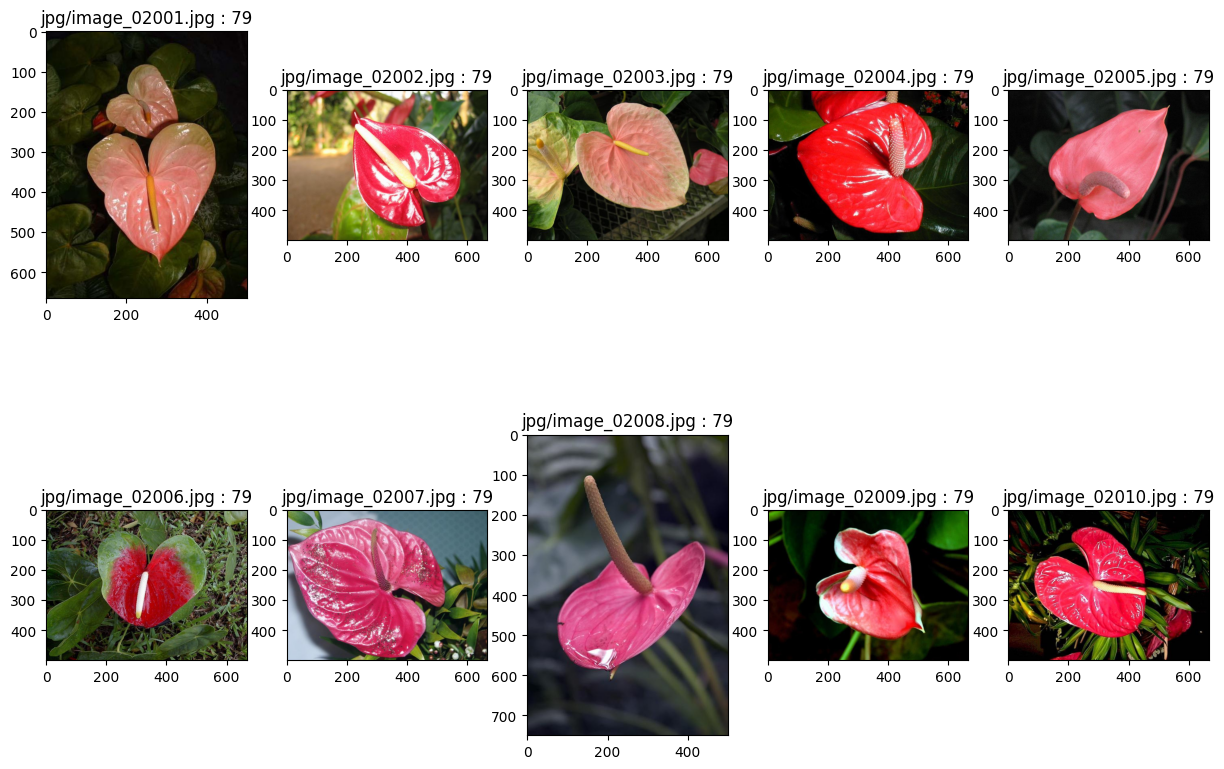

In [5]:
import matplotlib.pyplot as plt
import cv2

dataset['image'][1001], dataset['label'][1001]

# displays a few random images
fig, axes = plt.subplots(2, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(dataset['image'][i + 2000])  # reads image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # converts to RGB
    ax.set_title(f"{dataset['image'][i + 2000]} : {dataset['label'][i + 2000]}")  # title
    ax.imshow(img)

### Step 5 - Data Preprocessing and Augmentation
We will now, split the dataset into training (80%) and validation (20%) sets and apply various augmentations to the training images to increase the robustness of the model.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dataset, test_size=0.2, shuffle=True)

# image data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=[0.75, 1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# defining the image data generator for validation data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# converts labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# creates the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    dtype='str'
)

# creates the validation data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    dtype='str'
)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


### Step 6 - Build the ResNet50 Model
We will now load the ResNet50 pre-trained model and add custom layers to adapt it for the flower classification task.

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# adds custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # prevents overfitting
output = Dense(102, activation='softmax')(x)

# freezing the first half of the layers in the base model
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Step 7 - Compile the Model
Now we compile the model and set up the optimizer, loss function, and evaluation metrics.

In [8]:
from tensorflow.keras.optimizers import Adam

# compiling the model with adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,794,534 (98.40 MB)

 Trainable params: 23,566,950 (89.90 MB)

 Non-trainable params: 2,227,584 (8.50 MB)

### Step 8 - Train the Model
We will train the model for 40 epochs, using the training and validation data generators, and using a learning rate scheduler to reduce the learning rate if the validation loss stops improving.

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# callback to reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=40,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


204/204 ━━━━━━━━━━━━━━━━━━━━ 209s 758ms/step - accuracy: 0.0230 - loss: 5.3349 - val_accuracy: 0.0245 - val_loss: 4.7761 - learning_rate: 1.0000e-04
Epoch 2/40
  1/204 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - accuracy: 0.0938 - loss: 4.4076

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0938 - loss: 4.4076 - val_accuracy: 0.0000e+00 - val_loss: 4.5498 - learning_rate: 1.0000e-04
Epoch 3/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 150s 648ms/step - accuracy: 0.1150 - loss: 4.1237 - val_accuracy: 0.1140 - val_loss: 4.1829 - learning_rate: 1.0000e-04
Epoch 4/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.2188 - loss: 3.0963 - val_accuracy: 0.1667 - val_loss: 3.7663 - learning_rate: 1.0000e-04
Epoch 5/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 133s 630ms/step - accuracy: 0.2129 - loss: 3.3001 - val_accuracy: 0.2286 - val_loss: 3.2838 - learning_rate: 1.0000e-04
Epoch 6/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1875 - loss: 3.1496 - val_accuracy: 0.1667 - val_loss: 4.1615 - learning_rate: 1.0000e-04
Epoch 7/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 135s 648ms/step - accuracy: 0.3013 - loss: 2.8275 - val_accuracy: 0.2396 - val_loss: 3.5058 - learning_rate: 1.0000e-04
Epoch 8/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step -

### Step 9 - Evaluate the Model
Once model is trained, we evaluate its performance on the test set.

In [10]:
model.save("flowers102_model.keras")
model.evaluate(test_generator)

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8247 - loss: 0.6343


[0.5774654150009155, 0.8363858461380005]

### Step 10 - Plot Training and Validation Accuracy & Loss
Finally, let’s plot the training and validation accuracy and loss over the epochs to analyze the model’s performance.

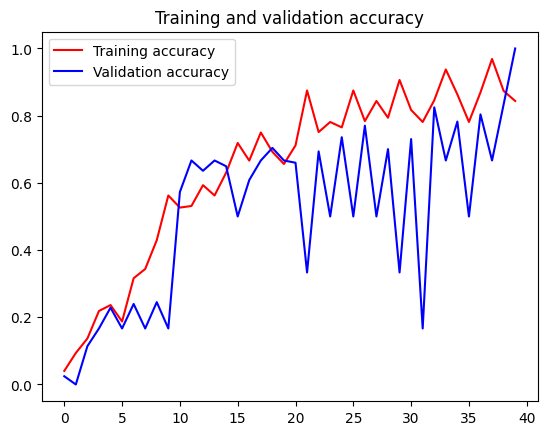

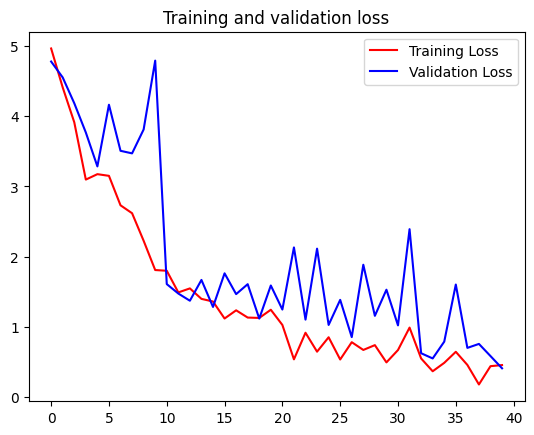

In [11]:
# plotting the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plotting the training and validation loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Conclusion

In this project, we successfully implemented a deep learning model using transfer learning and regularization techniques to classify flowers from the Flowers-102 dataset.

Our model's performance showed consistent improvements in training accuracy, indicating that the model is learning well from the training data. However, the validation accuracy displayed fluctuations, suggesting that the model is struggling to generalize effectively to unseen data.

To prevent overfitting, we incorporated regularization techniques, such as **Dropout** (0.5) and **BatchNormalization**. These strategies helped reduce overfitting, but there is still room for improvement. The training loss decreased steadily, showing good fitting to the training set, while the validation loss showed some erratic behavior, which indicates that more fine-tuning may be needed.

While the current model is showing promising results, further improvements could be made by experimenting with different architectures, hyperparameters, or more data augmentation techniques. Additionally, increasing the dataset size or introducing more diverse data could help the model generalize better.

For any queries or further discussion, feel free to reach out to me at **olwinchristian1626@gmail.com**.

Thank you!
